# Task 0 — Building the Biased Dataset

The whole point of this project is to show how easily a CNN takes shortcuts. So first I need a dataset where a shortcut actually exists.

The idea: take plain MNIST digits and drop them onto colored backgrounds. Each digit class gets its own background color — 0 is red, 1 is green, 2 is blue, and so on. The digit itself stays white/grey so it doesn't carry any color info. All the color signal lives in the background.

To make it look a bit more natural (and not just a flat block of color), each pixel in the background is a slightly different shade of the same hue. So a "red" background has some dark red pixels, some bright red pixels, etc. Looks textured, but the overall hue is unmistakable.

Here's the trick: in training, **95% of images have the "right" color** for their digit. A model that just reads background color can hit ~95% accuracy without ever learning what a "3" looks like. Then in the test set I flip it — every image gets the *wrong* color — and we see if the model actually learned shapes or just memorized colors.


In [70]:
import sys
from pathlib import Path
import importlib

ROOT = Path().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

# reload so we always pick up the latest code changes
import src.data.colored_mnist
import src.data.datasets
import src.data
importlib.reload(src.data.colored_mnist)
importlib.reload(src.data.datasets)
importlib.reload(src.data)

import numpy as np
import matplotlib.pyplot as plt
import torch

from src.utils.seed import seed_everything, SeedConfig
from src.data import generate_colored_mnist, load_meta, get_color_names, make_dominant_color_map
from src.data import load_split, compute_overall_correlation, compute_empirical_correlation, get_dataloaders

SEED = 42
DATA_DIR = ROOT / "data" / "colored_mnist"
seed_everything(SeedConfig(seed=SEED))

print(f"saving to: {DATA_DIR}")


saving to: /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist


## Generate the dataset

Wipe any old version and regenerate from scratch. 95% color correlation, small amount of per-pixel shade noise.


In [71]:
from src.data.colored_mnist import generate_colored_mnist, load_meta
import shutil

# start fresh every time
if (DATA_DIR / "meta.json").exists():
    shutil.rmtree(DATA_DIR)

generate_colored_mnist(DATA_DIR, seed=SEED, corr=0.95, noise_std=0.15)

meta = load_meta(DATA_DIR)
print(f"\ncorrelation: {meta['correlation']}")


generating colored-mnist (seed=42, corr=95%)
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:18<00:00, 522kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 104kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:03<00:00, 517kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.52MB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

  train: 54000, val: 6000, test_hard: 10000
  saved train: 54000 samples
  saved val: 6000 samples
  saved test_hard: 10000 samples
  train: 95.2% dominant
  val: 94.6% dominant
  test_hard: 0.0% dominant
done -> /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist

correlation: 0.95


## Sanity-check the correlations

Train and val should be ~95% dominant (matching the 0.95 corr we set). Test_hard should be 0% — every image deliberately gets the wrong color.


In [72]:
dominant_map = make_dominant_color_map()
color_names = get_color_names()

for split in ["train", "val", "test_hard"]:
    data = load_split(DATA_DIR, split)
    corr = compute_overall_correlation(data["labels"], data["color_ids"], dominant_map)
    print(f"{split}: {corr*100:.1f}% dominant")


train: 95.2% dominant
val: 94.6% dominant
test_hard: 0.0% dominant


## Sample images

Quick visual check. In training most images should have the "right" color for their digit (marked ✓). In test_hard every single image should have the wrong color (all ✗).


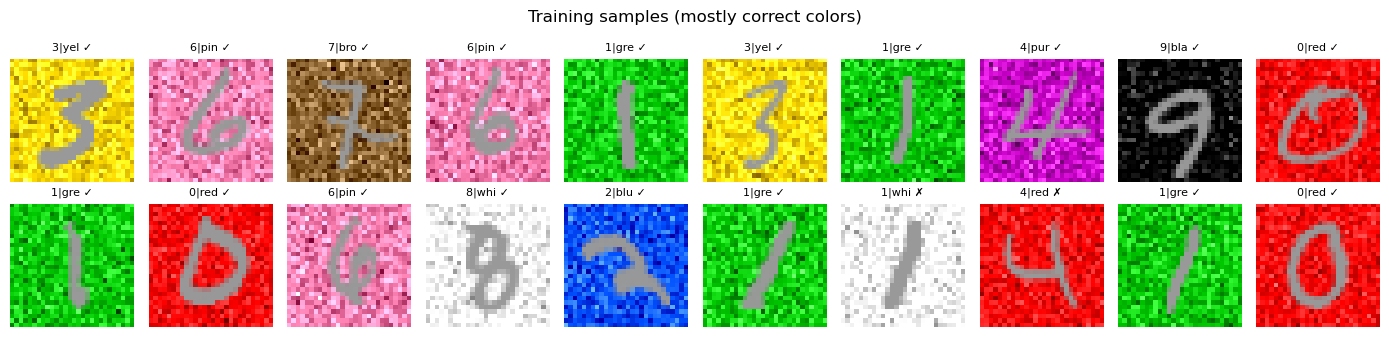

In [73]:
# grab some training samples and see what they look like
train_data = torch.load(DATA_DIR / "train.pt", weights_only=False)
imgs, labels, color_ids = train_data["images"], train_data["labels"], train_data["color_ids"]

fig, axes = plt.subplots(2, 10, figsize=(14, 3.5))
for i in range(20):
    img = imgs[i].permute(1, 2, 0).numpy()
    lbl, cid = int(labels[i]), int(color_ids[i])
    match = "✓" if cid == dominant_map[lbl] else "✗"
    axes[i//10, i%10].imshow(img)
    axes[i//10, i%10].axis('off')
    axes[i//10, i%10].set_title(f"{lbl}|{color_names[cid][:3]} {match}", fontsize=8)
fig.suptitle("Training samples (mostly correct colors)")
plt.tight_layout()
plt.show()


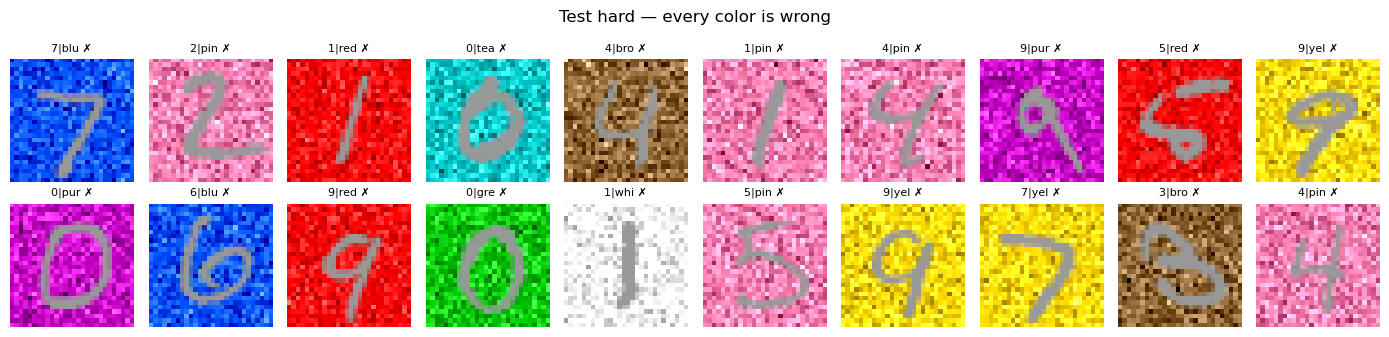

In [74]:
# now the test set — every color should be wrong
test_data = load_split(DATA_DIR, "test_hard")
imgs_test, labels_test, color_ids_test = test_data["images"], test_data["labels"], test_data["color_ids"]

fig, axes = plt.subplots(2, 10, figsize=(14, 3.5))
for i in range(20):
    img = imgs_test[i].permute(1, 2, 0).numpy()
    lbl, cid = int(labels_test[i]), int(color_ids_test[i])
    match = "✓" if cid == dominant_map[lbl] else "✗"
    axes[i//10, i%10].imshow(img)
    axes[i//10, i%10].axis('off')
    axes[i//10, i%10].set_title(f"{lbl}|{color_names[cid][:3]} {match}", fontsize=8)
fig.suptitle("Test hard — every color is wrong")
plt.tight_layout()
plt.show()


In [75]:
# make sure the dataloaders work and the split sizes look right
loaders = get_dataloaders({"root": str(DATA_DIR), "batch_size": 64, "num_workers": 0})
for name, loader in loaders.items():
    print(f"{name}: {len(loader.dataset)} samples")


train: 54000 samples
val: 6000 samples
test_hard: 10000 samples


## What I ended up with

A color-biased version of MNIST. Every image is a **white/grey digit** sitting on a **colored textured background**. The background is one distinct hue — red, green, blue, yellow, purple, teal, pink, brown, white, or black — but each pixel is a randomly different shade of that hue, so it looks grainy and natural rather than a flat slab of color.

The 10 colors were picked to be as visually distinct as possible. Each color maps 1-to-1 with a digit class: 0=red, 1=green, 2=blue, 3=yellow, 4=purple, 5=teal, 6=pink, 7=brown, 8=white, 9=black.

**The numbers:**
- 54,000 training images, 6,000 validation, 10,000 test
- Train/val: ~95% of images have the "correct" background color for their digit
- Test_hard: **0% correct** — every image deliberately gets a wrong color
